In [1]:
# load libs
import numpy as np 
import scipy 
import pandas as pd
import os
import matplotlib.pyplot as plt #import matplotlib as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns #import mat73
import pickle as pkl
from datetime import datetime
import mne
from mne.viz import plot_topomap
from mne.viz import set_3d_title, set_3d_view
from scipy.linalg import svd
sns.set_theme() # set the plotting atmosphere

In [2]:
# important functions
def GetDims(DictIn):
    """This script gets the dims of data 
    for later indexing"""
    iter = int(len(DictIn.keys())-1)
    NumDims = np.zeros((int(iter),3))
    for Sind in range(iter):
        NumDims[Sind,:] = DictIn[Sind].shape
    return NumDims
    
def DataSort(dictIn, sIn):
    """This function takes 1 subjects data.
        Data contains 6 keys per bin.
        Returns: Pre, Post and Post-Pre, and 2*(Post-Pre)/(Pre+Post) """
    BinDiffArith_Out = {}
    BinBaseDiff_Out = {}
    BinPrePost_Out = {}
    fx = dictIn[sIn] # import data 

    for harmonic in range(NumHarms):

        fx_avg = np.zeros((NumBins,int(len(chanList)),2)) # bins x channel x pre/post
        fx_diff = np.zeros((NumBins,int(len(chanList))))
        fx_sum = np.zeros_like(fx_diff)
        fx_diffArith = np.zeros_like(fx_diff)

        nt = int((fx[harmonic].shape[2])/2)
        fx_temp = np.reshape(fx[harmonic], newshape = (NumBins,int(NumChans),2,nt), order = 'F')
        #print(fx[harmonic].shape)
        #get pre and post induction average
        for induCo in range(2):
            fx_avg[:,:,induCo] = np.nanmean(fx_temp[:,:,induCo,:], axis = 2) # 6 x 128 
        for bin in range(NumBins):
            fx_diff[bin,:] = fx_avg[bin,:,1] - fx_avg[bin,:,0] # post - pre
            fx_sum[bin,:] = fx_avg[bin,:,1] + fx_avg[bin,:,0] 
            fx_diffArith[bin,:] = 2*(((fx_diff[bin,:])/(fx_sum[bin,:])))

        BinDiffArith_Out[harmonic] = fx_diffArith
        BinBaseDiff_Out[harmonic] = fx_diff
        BinPrePost_Out[harmonic] = fx_avg

    return BinDiffArith_Out,BinBaseDiff_Out,BinPrePost_Out

### Import all files that will be sorted and exported from + into another .mat file

In [3]:
# Main Directory of processed file from MatLab
#MainDir = 'D:\\AttnXV3_analysis\\RCA_F1\\AvgCRFs\\' # set dir
MainDir = 'C:\\plimon\\LTP_analysis\\eegMatFiles\\AllMAT' # set dir
os.chdir(MainDir) # change old dir, to this dir
dataFileNames = os.listdir(MainDir) # list files in dir
print(f'Total Files Avilable: {len(dataFileNames)}')
##############################################
FileN = dataFileNames[0]# choose one                        
file_path1 = os.path.join(MainDir, FileN) # join paths and prep 2 load
print('Current WD:',file_path1) # does path exist ... ?
print('Does File #1 Exist?',os.path.exists(file_path1)) # yes or no

Total Files Avilable: 1
Current WD: C:\plimon\LTP_analysis\eegMatFiles\AllMAT\AllSubj_MatFiles_C1_20240412_110418.pkl
Does File #1 Exist? True


## Get Participant FileName and Expt Session Condition: AttnL == 1 or AttnR == 0 

In [4]:
NumBins = 6
NumHarms = 4

#### Print Keys in original data

In [5]:
loadData = pkl.load(open(file_path1, 'rb'))
print(loadData.keys())
print(len(loadData['RawData'].keys()))

dict_keys(['RawData', 'SubjNames'])
50


In [6]:
NumSubs = int(len(loadData['SubjNames']))
print(f'Subject Files Found: {NumSubs}')
files = loadData['SubjNames']

file_label = [files.replace('_','-') for files in files] # set files in single format 
print((file_label))

Subject Files Found: 50
['nl-2652-attnL-20231003-1635-RLS.mat', 'nl-2655-attnL-20231009-1303-RLS.mat', 'nl-2657-attnL-20231013-1508-RLS.mat', 'nl-2658-attnR-20231020-1052-RLS.mat', 'nl-2661-attnL-20231018-1322-RLS.mat', 'nl-2661-attnR-20231017-1358-RLS.mat', 'nl-2663-attnR2-20231030-1659-RLS.mat', 'nl-2664-attnR-20231019-1145-RLS.mat', 'nl-2665-attnL-20231024-1329-RLS.mat', 'nl-2665-attnR-20231019-1512-RLS.mat', 'nl-2666-attnL-20231023-1612-RLS.mat', 'nl-2666-attnR-20231019-1643-RLS.mat', 'nl-2667-attnL-20231025-1522-RLS.mat', 'nl-2667-attnR-20231023-0947-RLS.mat', 'nl-2668-attnL-20231027-1251-RLS.mat', 'nl-2668-attnR-20231023-1058-RLS.mat', 'nl-2669-attnL-20231024-1432-RLS.mat', 'nl-2669-attnR-20231023-1241-RLS.mat', 'nl-2670-attnL-20231201-1521-RLS.mat', 'nl-2670-attnR-20231024-0941-RLS.mat', 'nl-2671-attnL-20231024-1107-RLS.mat', 'nl-2671-attnR-20231025-1419-RLS.mat', 'nl-2672-attnL-20231030-1540-RLS.mat', 'nl-2672-attnR-20231025-1305-RLS.mat', 'nl-2674-attnL-20231026-1107-RLS.mat',

In [7]:
string_ind = '-'

SubjName = [] # subject data in 
ExptSession = [] # AttnL, AttnR

for s in range(NumSubs):
    fnameIn = file_label[s]
    sNum = fnameIn.split(string_ind)[1] # subject name 
    exptSess = fnameIn.split(string_ind)[2] # expt session performed

    SubjName.append(sNum)
    ExptSession.append(exptSess)

    ExptSess_bool = [1 if x == 'attnL' else 0 for x in ExptSession] # attnL == 1 , attnR == 0

#### small sanity check for file labels and correct sorting ...

In [8]:
si = 11
print(file_label[si], SubjName[si], ExptSession[si],ExptSess_bool[si])

nl-2666-attnR-20231019-1643-RLS.mat 2666 attnR 0


In [9]:
ExptInformation = {}

ExptInformation['OrignalFileName'] = file_label
ExptInformation['FileSubjNumber'] = SubjName
ExptInformation['attnX_label'] = ExptSession
ExptInformation['attnX_binarybool'] = ExptSess_bool

In [10]:
Dims = GetDims(loadData['RawData']) # shape of all subjs data

print(f'Variability of Rows: {np.unique(Dims[:,0],return_counts = True)}')
print(f'Variability of Chans: {np.unique(Dims[:,1])}')
print(f'Variability of Trials: {np.unique(Dims[:,2], return_counts = True)}')
NumChans = ((np.unique(Dims[:,1])))[0]

Variability of Rows: (array([112., 126.]), array([10, 39], dtype=int64))
Variability of Chans: [128.]
Variability of Trials: (array([78., 80.]), array([47,  2], dtype=int64))


In [11]:
s_iters = int(Dims.shape[0])

splitRowInd = []
splitCondInd = []

for sIn in range(s_iters):
    dataDimsIn= Dims[sIn,:] # info for indexing rows, cols and trials
    splitRowInd.append(int((dataDimsIn[0]/2))) # cutoff for splitting data along real-imag axis
    splitCondInd.append(int(dataDimsIn[2]/2)) # cutoff for splitting trials as pre and post  
splitRowInd = np.array(splitRowInd)
splitCondInd = np.array(splitCondInd)

### Select Channels of Interest to Visualize Later

In [12]:
elecLeftLateral=[51,52,60,58,59,64,65,68,69]
elecLeftMedial=[72,75,81,70,71,74]
elecRightMedial=[72,75,81,76,83,82]
elecMedial=[72,75,81,70,71,74,76,83,82]
elecRightLateral=[97,92,85,96,91,95,90,94,88]
extraChans = np.arange(50,100,1)
extra = [107,101,47,42,37,31,102,46,41,45,49,103,108,113,108,99]
AnalysisChans = [elecLeftLateral,elecLeftMedial,elecRightMedial,elecMedial,elecRightLateral,extraChans,extra]
ExportChans = np.unique(np.sort(np.concatenate(AnalysisChans))) # Combine array for chans of interest
VisChans  = ExportChans - 1
print(f'Channels to be visualized: {VisChans}')

Channels to be visualized: [ 30  36  40  41  44  45  46  48  49  50  51  52  53  54  55  56  57  58
  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98 100 101 102 106 107 112]


#### Make Bool mask for MNE Topoplots

In [13]:
chanList = np.arange(0,Dims[0,1],1)
ocm = np.zeros_like((chanList))
ocm[VisChans] = True # set good chans to true

ocm_chans = ocm.astype(bool)
print(ocm_chans)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
  True False False False  True  True False False  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True False False False  True  True
 False False False False  True False False False False False False False
 False False False False False False False False]


#### Combine Real and Imaginary Components of data

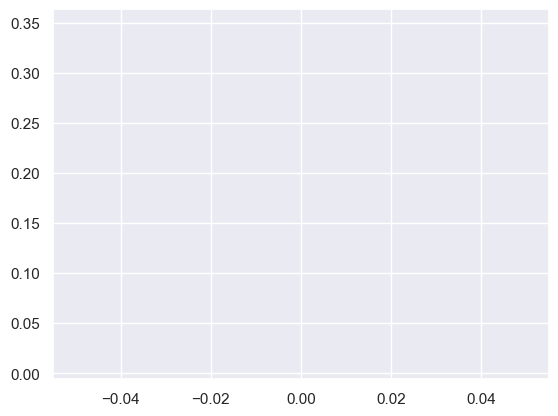

In [77]:
# maybe has to add a mask before hypot is computed
cleanData = {}
for sIn in range(s_iters):
    RawData = loadData['RawData'][sIn]
     # reshape data so 0 = real and 1 = imaginary values 
    reshapeData  = RawData.reshape((splitRowInd[sIn]),2,int(Dims[sIn,1]),int(Dims[sIn,2]), order = 'A')
    # replace bad chans with nan's
    reshapeData[reshapeData == 0] = np.nan
    # empty dataframe
    comboData = np.zeros((splitRowInd[sIn],int(Dims[sIn,1]),int(Dims[sIn,2])))
    unique_Iter = splitRowInd[sIn]
    for val in range(unique_Iter):
        comboData[val,:,:] = np.hypot(reshapeData[val,0,:,:],reshapeData[val,1,:,:])
    cleanData[sIn] = comboData
    temp=(np.nanmean(RawData[:,75,:],axis = 1))
    nr = np.shape(temp)[0]
    NumRows = int(nr/2)
    tempr=temp[0:NumRows]
    tempi=temp[NumRows:]
    d1=np.hypot(np.nanmean(tempr),np.nanmean(tempi))
    plt.plot(d1)

#### Get Data Per Bin and Store in Dict, Remove Prelude Bins

In [15]:
preBins = NumBins + 1 #(+1 bc prelude bin)
GoodBinData = {}

for sIn in range(s_iters):
    dIn = cleanData[sIn] # import 1 subjs data 
    rmvBinInd = np.array(np.arange(0,splitRowInd[sIn],preBins)) # set indices to remove 1st (oth bin) out of every 7th
    ind_arr = np.ones(splitRowInd[sIn]) # all rows good as default
    ind_arr[rmvBinInd] = False # id prelude bins
    GoodBinData[sIn] = dIn[ind_arr == 1,:,:] # save into dict 

## **Check Point #1** : Make sure 1F1 harmonic data is **NOT** included in analysis

In [29]:
HarmonicDataCo = 4 # should be 2f 4 f 6f and 8f data
HemiFieldDataCo = 2 # should exist for f1 and f2
idealHarmOrd = HarmonicDataCo*HemiFieldDataCo # 8

allHemiData = {}
for sIn in range(s_iters):
# if data along rows is not divisible, remove 1f1 data
    if (GoodBinData[sIn].shape[0] % idealHarmOrd) != 0:
        print(f'File # {sIn+1} contains 1F1 data, now removing ...')
        allHemiData[sIn] = GoodBinData[sIn][NumBins:,:,:] # remove the 1st 6 values of data 
    else:
        print(f'File # {sIn+1} was preserved')
        allHemiData[sIn] = GoodBinData[sIn]

File # 1 contains 1F1 data, now removing ...
File # 2 contains 1F1 data, now removing ...
File # 3 contains 1F1 data, now removing ...
File # 4 contains 1F1 data, now removing ...
File # 5 contains 1F1 data, now removing ...
File # 6 contains 1F1 data, now removing ...
File # 7 contains 1F1 data, now removing ...
File # 8 contains 1F1 data, now removing ...
File # 9 contains 1F1 data, now removing ...
File # 10 contains 1F1 data, now removing ...
File # 11 contains 1F1 data, now removing ...
File # 12 contains 1F1 data, now removing ...
File # 13 contains 1F1 data, now removing ...
File # 14 contains 1F1 data, now removing ...
File # 15 contains 1F1 data, now removing ...
File # 16 contains 1F1 data, now removing ...
File # 17 contains 1F1 data, now removing ...
File # 18 contains 1F1 data, now removing ...
File # 19 contains 1F1 data, now removing ...
File # 20 contains 1F1 data, now removing ...
File # 21 contains 1F1 data, now removing ...
File # 22 contains 1F1 data, now removing .

#### F1 and F2 data are stacked on top of each other so here we split them :)

In [17]:
xF1HemiData = {} # data is : 2f1 4f1 6f1 8f1
xF2HemiData = {} # data is  2f2 4f2 6f2 8f2

for sIn in range(s_iters):
    HarmonicCutoff = int(allHemiData[sIn].shape[0] / 2)
    xF1HemiData[sIn] = np.array(allHemiData[sIn][:HarmonicCutoff,:,:]) # harmonics x channels x trials  = 4 x 128 x 78
    xF2HemiData[sIn] = np.array(allHemiData[sIn][HarmonicCutoff:,:,:]) # harmonics x channels x trials 

In [18]:
xF1HemiBins = {}
xF2HemiBins = {}
for sIn in range(s_iters):
    x1 = xF1HemiData[sIn]
    x2 = xF2HemiData[sIn]
    HarmonicEpochs = np.array(np.arange(0,x1.shape[0],NumBins)) # index to segment bins

    xF1HemiBins[sIn] = {}
    xF2HemiBins[sIn] = {}
    for xFX in range(HarmonicDataCo):
        xF1HemiBins[sIn][xFX] = x1[HarmonicEpochs[xFX]:HarmonicEpochs[xFX]+(NumBins),:,:]
        xF2HemiBins[sIn][xFX] = x2[HarmonicEpochs[xFX]:HarmonicEpochs[xFX]+(NumBins),:,:]
        #print(xF1HemiBins[sIn][xFX].shape)

(6, 128, 78)


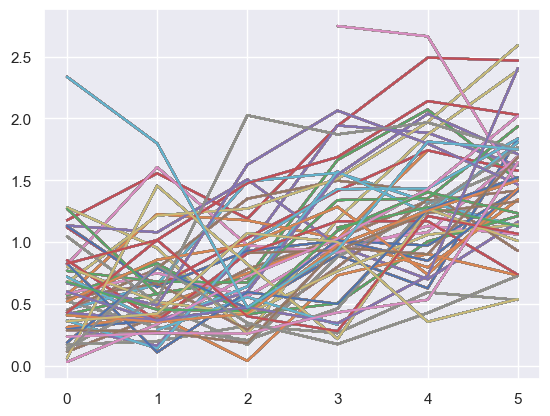

In [41]:
xF1HemiBins.keys()
xF1HemiBins[0].keys()
harm2f2 = xF1HemiBins[0][0]
print(harm2f2.shape)

for i in range(50):
    plt.plot(xF1HemiBins[12][0][:,75,1:50])

### seperate data into pre and post 

In [19]:
bda_f1 = {}
bbd_f1 = {}
bpp_f1 = {}
for s in range(s_iters):
    #print(f'now sorting data file # {s}')
    bda_f1[s], bbd_f1[s], bpp_f1[s] = DataSort(xF1HemiBins, sIn = s)

F1Out = {}
F1Out['BinDiffArith'] =  bda_f1 # 2*(post-pre)/post+pre
F1Out['BinBaseDiff'] = bbd_f1   # post - pre
F1Out['BinPrePost'] =  bpp_f1   # pre AND post data is in these subkeys

In [20]:
bda_f2 = {}
bbd_f2 = {}
bpp_f2 = {}
for s in range(s_iters):
    #print(f'now sorting data file # {s}')
    bda_f2[s], bbd_f2[s], bpp_f2[s] = DataSort(xF2HemiBins, sIn = s)

F2Out = {}
F2Out['BinDiffArith'] =  bda_f2 # 2*(post-pre)/post+pre
F2Out['BinBaseDiff'] = bbd_f2   # post - pre
F2Out['BinPrePost'] =  bpp_f2   # pre AND post data is in these subkeys

In [21]:
DataOut = {}
DataOut['F1_Data'] = F1Out # all F1 data
DataOut['F2_Data'] = F2Out # all F2 data
DataOut['eegSubInfo'] = ExptInformation # arrays needed for indexing what groups to average together 

In [22]:
DataOutDir = 'C:\\plimon\\LTP_analysis\\eegClean'
FileOutName = 'ProcessedData_Reviz' 
dnt = datetime.now() # add date and time bc im wreckless when saving ..
fdnt = dnt.strftime("%Y%m%d_%H%M%S") # set the above as a string ...
FileN = f'{FileOutName}_{fdnt}.pkl'  # make proper file out name

NewFileNPath = os.path.join(DataOutDir,FileN) # path where data will be 
print('Full New File Dir: ', NewFileNPath) # sanity check

Full New File Dir:  C:\plimon\LTP_analysis\eegClean\ProcessedData_Reviz_20240418_154916.pkl


In [23]:
saveFile = 'y'

if saveFile == 'y':
 with open(NewFileNPath, 'wb') as file:
    pkl.dump(DataOut, file, protocol=pkl.HIGHEST_PROTOCOL)
    print('Sorted Data Saved! :))')
else:
    print('Did Not Save File! Change file name before switching to y!')

Sorted Data Saved! :))


# Select EEG Montage for MNE

In [24]:
montageIn = mne.channels.make_standard_montage("GSN-HydroCel-128")
info = mne.create_info(ch_names=montageIn.ch_names, sfreq=1, ch_types="eeg")
info.set_montage(montageIn)
print(montageIn)

<DigMontage | 0 extras (headshape), 0 HPIs, 3 fiducials, 128 channels>


## Visualize Data

(128,)


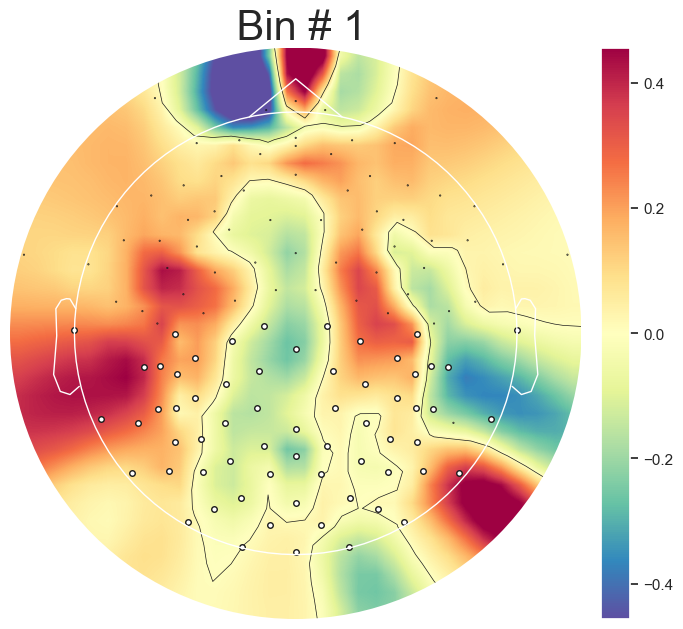

(128,)


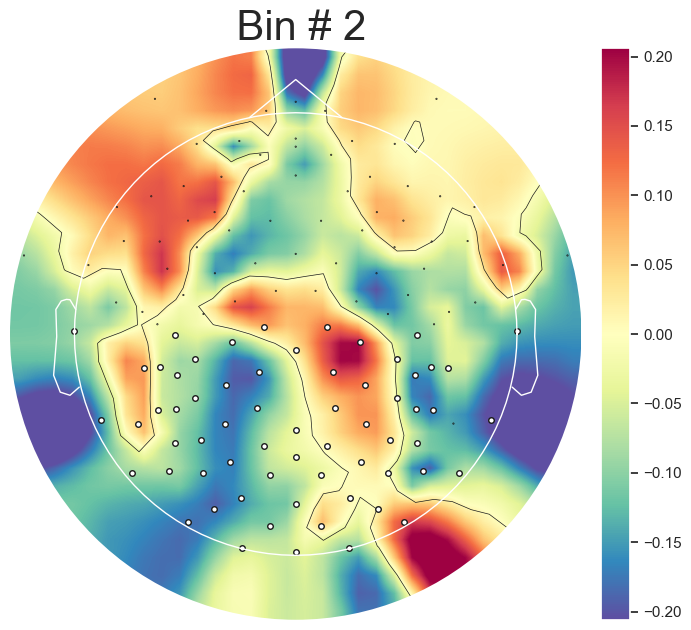

(128,)


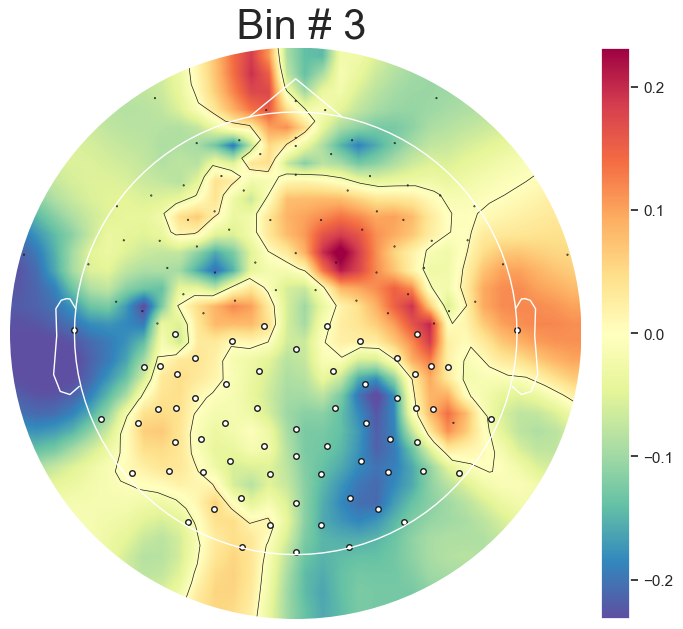

(128,)


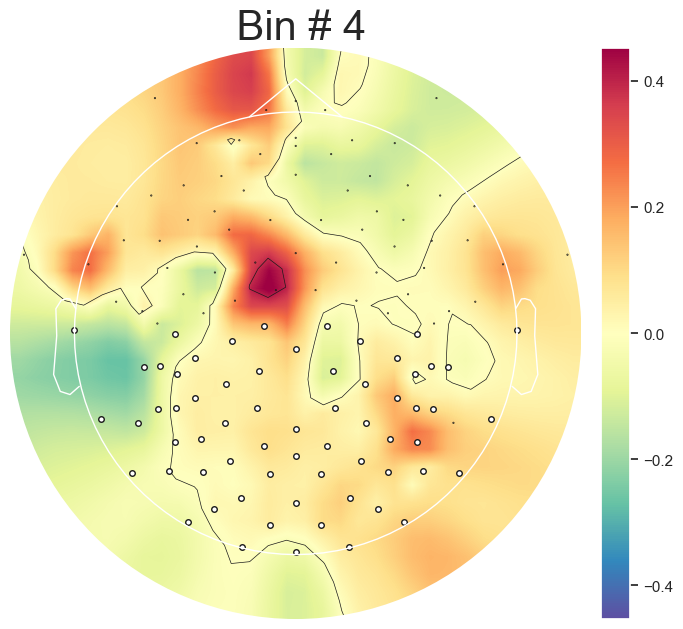

(128,)


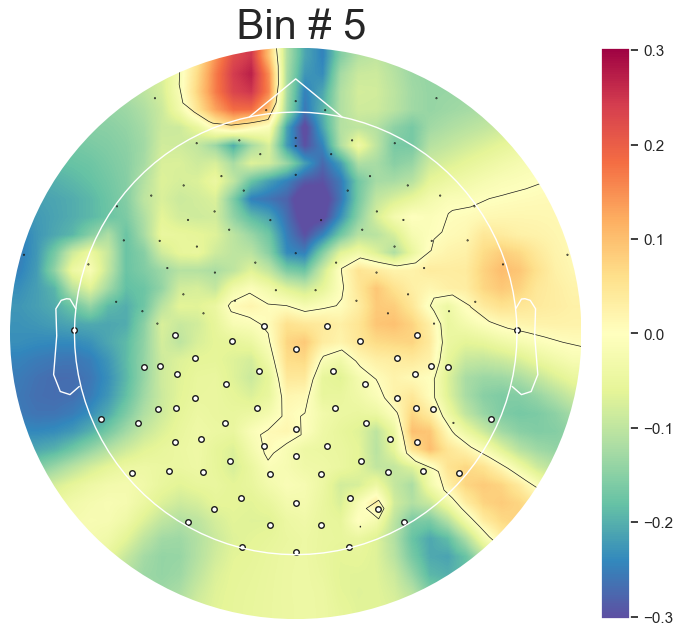

(128,)


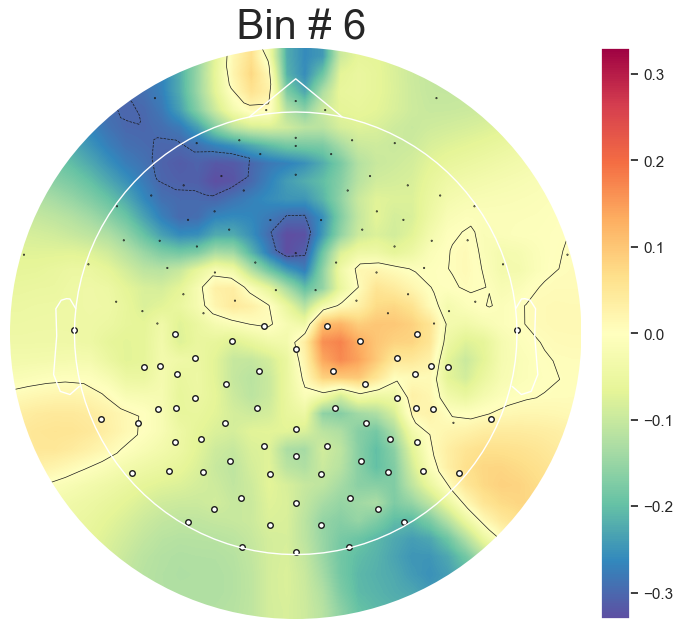

In [27]:
for i in range(NumBins):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 10),gridspec_kw=dict(height_ratios=[3]))
    axes.set_title(f' Bin # {(i+1)}', fontsize = 30)
    axes.axis('off')

    dataIn = np.array(bda_f1[15][0][i,:]) # plot data per bin
    print(dataIn.shape)
    # hashtag below to plot all channel activity
    #dataIn[~ocm_chans] = 0 # want to index good channels only and set the rest channels to 0 value
    im,_ = plot_topomap(dataIn, info,mask = ocm, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 1)
    divider = make_axes_locatable(axes)
    cax = divider.append_axes('right', size='5%', pad=0.2)
    cbar = plt.colorbar(im, cax=cax)
    plt.show()

In [ ]:
# topodata = p[0,:,:].T
# print(topodata.shape)
# emptyChData = np.zeros((1,6))
# print(emptyChData.shape)

# dataFull = np.array(np.concatenate((topodata,emptyChData)))

# data = dataFull[:,4]

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10),gridspec_kw=dict(height_ratios=[3]))
# axes.set_title(f'subj topo plot', fontsize = 30)
# # placeholder = np.random.random((10, 10))
# # axes.imshow(placeholder)
# axes.axis('off')

# #info = create_info(ch_names=montageIn._names, sfreq=1, ch_types='eeg')
# # channel names I provided are part of a standard montage
# #info.set_montage(montageIn) # import file)
# im,_ = plot_topomap(data, info, axes = axes, show =False,cmap = 'Spectral_r', res = 32, contours = 8)
# divider = make_axes_locatable(axes)
# cax = divider.append_axes('right', size='5%', pad=0.2)
# cbar = plt.colorbar(im, cax=cax)
# plt.show()

### Good confined example of what data formate is supposed to look like for mne plotting success

In [ ]:
# from mne import create_info
# from mne.viz import plot_topomap
# import numpy as np

# # create array with 4 points for our 4 channels
# # in the same order as provided in ch_names
# data = np.random.randn(4)  
# info = create_info(ch_names=['CPz', 'Oz', 'POz', 'Fz'], sfreq=1000, ch_types='eeg')
# # channel names I provided are part of a standard montage
# info.set_montage('standard_1020')

# plot_topomap(data, info)

In [ ]:
# topodata = p[0,:,:].T  # 128 x 6 - 0 -== 2f
# #have to add some fck channel data because egi file included one extra channel
# emptyChData = np.zeros((1,6)) # 1 x 6
# data = np.array(np.concatenate((topodata,emptyChData))) # 129 x 6 


# for i in range(6):
#     #plt.plot(topodata[:,i])
#     fig, axs = plt.subplots(figsize = (6,6))
#     axs.set_title(f'Bin # {i}')
#     axs.legend()
#     print(i)
#     dataIn = data[:,i]
#     mne.viz.plot_topomap(dataIn, info, axes = axs)

#### plot formats of the past and present(?)

In [ ]:
# fig = plt.figure(figsize = (10,10))
# ax = fig.add_subplot(111, projection='3d')
# montageIn.plot(kind='3d', axes=ax)
# ax.set_title('Sensor Locations')
# plt.show()
# # Plot the sensors on a 2D head model
# fig, ax = plt.subplots()
# montageIn.plot(kind='topomap', show_names=True, axes=ax)
# ax.set_title('Sensor Locations (2D)')
# plt.show()

In [ ]:
# #montge default info in case egi outut file fails me 
# montage_type = mne.channels.make_standard_montage("GSN-HydroCel-128")
# print(montage_type)

In [ ]:
# h_label = ['2F','4F','6F','8F']

# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF1_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Pre F1 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
#plt.show()
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF1_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Post F1 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF2_Data[0][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Pre F2 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')
# fig,axs = plt.subplots(6,1, figsize = (10,40))
# for i in range(6):
#     dIn = axs[i].imshow(XF2_Data[1][:,i,ExportChans],aspect='auto', cmap=sns.cubehelix_palette(as_cmap=True))
#     axs[i].set_xticks(np.arange(len(ExportChans)))
#     axs[i].set_xticklabels(ExportChans,rotation=45)
#     axs[i].set_yticks(np.arange(len(h_label)))  # Set y-ticks to match the length of y_labels
#     axs[i].set_yticklabels(h_label) 
#     axs[i].set_title('Post F2 Data')
#     axs[i].set_xlabel('Channels')
#     axs[i].set_ylabel('Amplitude')